In [3]:
import stan
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize']=5,5
plt.style.use('ggplot')

In [4]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

### Generate data

In [46]:
# Create data sampled from a mixture of gaussians
# define the parameters
np.random.seed(1)
mu0 = 2
sigma0 = 1.5
mu1 = 5
sigma1 = 1.3
p = 0.8 # mixture parameter
#sampling
out = []
bernoulli = np.random.binomial(1, p, size=1000)
for i in range(len(bernoulli)):
    if bernoulli[i] == 1:
        out.append(np.random.normal(mu0,sigma0))
    else:
        out.append(np.random.normal(mu1,sigma1))

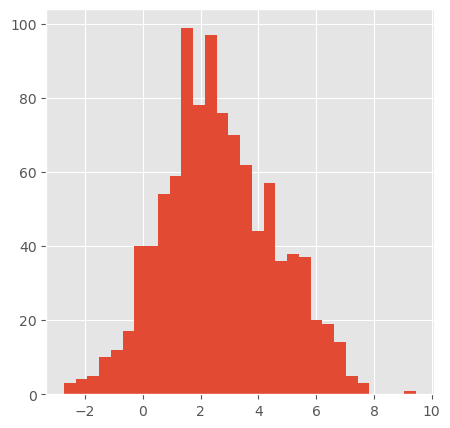

In [63]:
# We plot the data without labels (as we would actually see it!)
plt.hist(out, bins=30)
plt.show()

### Implementing the Gaussian Mixture model

In [48]:
my_mixture="""
data {
 int <lower=0> N;
 vector[N] y;
}

parameters {
  ordered[2] mu;  // This tells the sampler that always mu[1] < mu[2]
  //real mu[2];   // Study what happens if we use this line instead of the above  (it is called 'label switching')
  real<lower=0> sigma[2];
  real<lower=0, upper=1> theta;
}

model {   
 sigma ~ normal(0, 2);  
 mu[1] ~ normal(3, 2);
 mu[2] ~ normal(3, 2);
 theta ~ beta(1, 1);  //this is a uniform flat distribution for p in (0,1)
 for (n in 1:N)
   target += log_mix(theta,
                     normal_lpdf(y[n] | mu[1], sigma[1]),
                     normal_lpdf(y[n] | mu[2], sigma[2]));
}
"""

In [49]:
my_data={'N':len(out),'y':out}

In [50]:
model = stan.build(my_mixture, data=my_data, random_seed=1);

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ntvv7p0g/model_ceoo3iim.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ntvv7p0g/model_ceoo3iim.stan', line 18, column 1: The
    parameter theta is on the left-hand side of more than one tilde
    statement.


In [52]:
fit = model.sample(num_chains=5, num_samples=1000)

Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   1% (101/10000)
Sampling:   2% (201/10000)
Sampling:   3% (300/10000)
Sampling:   4% (400/10000)
Sampling:   5% (500/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  14% (1400/10000)
Sampling:  18% (1800/10000)
Sampling:  28% (2800/10000)
Sampling:  35% (3500/10000)
Sampling:  36% (3600/10000)
Sampling:  37% (3700/10000)
Sampling:  38% (3800/10000)
Sampling:  39% (3900/10000)
Sampling:  40% (4000/10000)
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 0.000337 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.37 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the followin

In [53]:
df = fit.to_frame() 

In [54]:
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,sigma.1,sigma.2,theta
draws,,,,,,,,,,,,
0,-2081.286964,0.828670,0.120567,2.0,7.0,0.0,2083.097357,2.466486,6.040714,1.805488,0.691627,0.911918
1,-2077.875577,0.994540,0.060051,3.0,7.0,0.0,2079.183856,2.210275,5.523963,1.753013,1.055584,0.881072
2,-2078.692142,0.681846,0.146824,3.0,7.0,0.0,2083.732047,1.781341,4.743379,1.408682,1.278407,0.685911
3,-2082.049462,0.967822,0.157554,4.0,23.0,0.0,2083.026385,2.057336,4.578836,1.757898,1.525309,0.783214
4,-2076.124927,0.982889,0.098455,4.0,31.0,0.0,2078.510018,2.208948,5.512449,1.616734,1.010748,0.852655
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-2079.793190,0.685864,0.120567,2.0,3.0,0.0,2080.367844,2.129844,5.119786,1.552145,1.025597,0.822579
4996,-2076.382096,0.943863,0.060051,4.0,31.0,0.0,2079.356726,2.076436,5.482081,1.609151,1.026468,0.839874
4997,-2079.043675,0.994879,0.146824,4.0,23.0,0.0,2082.142639,2.091118,5.395731,1.581178,0.960701,0.801554


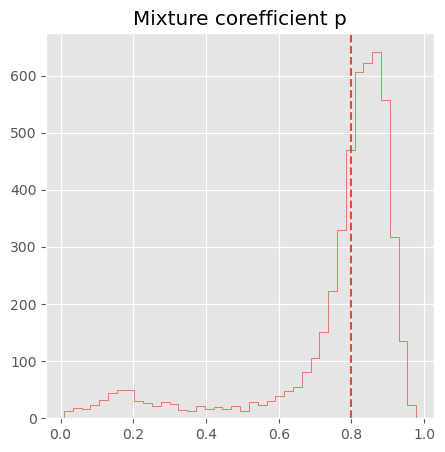

In [55]:
plt.hist(df['theta'], histtype='step', bins=40)
plt.axvline(x=p, linestyle='dashed')
#plt.axvline(x=1-p, linestyle='dashed')
plt.title('Mixture corefficient p')
plt.show()

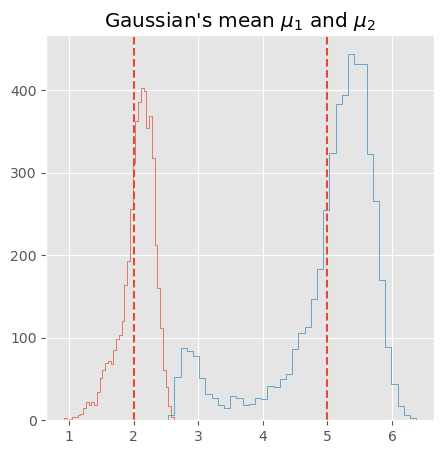

In [56]:
plt.hist(df['mu.1'],histtype='step', bins=40, label='mu1')
plt.hist(df['mu.2'],histtype='step', bins=40, label='mu2')
plt.axvline(x=mu0, linestyle='dashed')
plt.axvline(x=mu1, linestyle='dashed')
plt.title("Gaussian's mean $\mu_1$ and $\mu_2$")
plt.show()

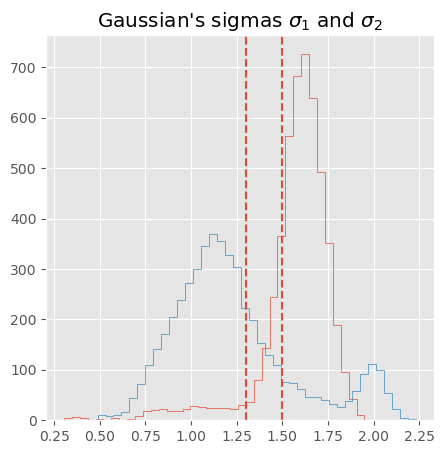

In [58]:
plt.hist(df['sigma.1'],histtype='step', bins=40, label='sigma1')
plt.hist(df['sigma.2'],histtype='step', bins=40, label='sigma2')
plt.axvline(x=sigma0, linestyle='dashed')
plt.axvline(x=sigma1, linestyle='dashed')
plt.title("Gaussian's sigmas $\sigma_1$ and $\sigma_2$")
plt.show()